# Import Necessary Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [4]:
# Connect  to drive to load dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [5]:
# Loading json file
data = pd.read_json('/content/drive/MyDrive/Electronics_5.json',lines=True)

# Basic Checks

In [6]:
# Checking dataset
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [8]:
data.shape

(1689188, 9)

In [9]:
# Checking dataset structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689188 entries, 0 to 1689187
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   reviewerID      1689188 non-null  object
 1   asin            1689188 non-null  object
 2   reviewerName    1664458 non-null  object
 3   helpful         1689188 non-null  object
 4   reviewText      1689188 non-null  object
 5   overall         1689188 non-null  int64 
 6   summary         1689188 non-null  object
 7   unixReviewTime  1689188 non-null  int64 
 8   reviewTime      1689188 non-null  object
dtypes: int64(2), object(7)
memory usage: 116.0+ MB


### For text-based sentiment classification, we only need the features that describe:

* What the customer said
* Whether the sentiment was positive/negative (the label)

### So,Required Features for Sentiment Analysis are as below:

* reviewText → input text expressing sentiment
* overall	(Rating score) → used as sentiment label (e.g., positive/negative)
* summary → Short headline — can be combined with reviewText

# Creating final Dataset

In [10]:
# Copying from original dataset to create our required dataset
df = data[['reviewText', 'overall', 'summary']].copy()
df.head()

,reviewText,overall,summary
0,We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!
1,"I'm a professional OTR truck driver, and I bou...",1,Very Disappointed
2,"Well, what can I say. I've had this unit in m...",3,1st impression
3,"Not going to write a long review, even thought...",2,"Great grafics, POOR GPS"
4,I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support"


In [11]:
# Creating a function to create sentiment label
def label_sentiment(rating):
    if rating <= 2:
        return "negative"
    elif rating == 3:
        return "neutral"
    else:
        return "positive"
df['sentiment'] = df['overall'].apply(label_sentiment)

df.head()

,reviewText,overall,summary,sentiment
0,We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,positive
1,"I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,negative
2,"Well, what can I say. I've had this unit in m...",3,1st impression,neutral
3,"Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",negative
4,I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",negative


In [12]:
# Creating a  column to see text length
df['Text_length'] = df['reviewText'].apply(len)
df.head()

,reviewText,overall,summary,sentiment,Text_length
0,We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,positive,805
1,"I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,negative,2175
2,"Well, what can I say. I've had this unit in m...",3,1st impression,neutral,4607
3,"Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",negative,2246
4,I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",negative,1076


In [13]:
# Checking the dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689188 entries, 0 to 1689187
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   reviewText   1689188 non-null  object
 1   overall      1689188 non-null  int64 
 2   summary      1689188 non-null  object
 3   sentiment    1689188 non-null  object
 4   Text_length  1689188 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 64.4+ MB


In [14]:
# Checking the longest review
df[df['Text_length'] == df['Text_length'].max()]['reviewText'].iloc[0]

'I\'ll throw out some important information first... this package doesn\'t include the Panasonic SH-FX71 wireless kit. This will need to be purchased in order to have the "wireless" rear speakers but at the time of this review, there are no retailers that carry it. I am lucky to have a previous 2 year old Panasonic home theatre system that I bought the SH-FX71 kit for that model and I am using the wireless kit with this new model and it works as advertised. The sound doesn\'t cutout when anyone walks through the family room and it doesn\'t lose signal from the receiver it works perfectly and I have a pretty big family room. If you absolutely need the wireless kit, Panasonic does sell older home theatres in a box that includes the kit. Try looking up the SH-FX71 on Panasonic.com and it will state what home theaters in a box include/support the kit. As far as buying the kit by itself... it hasn\'t been sold in retail in the past year as far as my knowledge which questions on when it will

In [15]:
# Checking the smallest review
df[df['Text_length'] == df['Text_length'].min()]['reviewText'].iloc[0]

''

In [16]:
# Checking any duplicate value
print(df['reviewText'].duplicated().sum())

2019


In [17]:
# Checking rows containing duplicate reviewtext
df[df['reviewText'].duplicated(keep=False)].head(10)

,reviewText,overall,summary,sentiment,Text_length
149,,5,Works perfectly for 400 x 200 VESA mount Hitek...,positive,0
293,,5,Best Tablet On A Budget!,positive,0
1114,Just as described.,5,Five Stars,positive,18
1212,,5,Ryan's little quick review of the Sony ICF-S79V.,positive,0
1660,I had no idea what this cable was because I fo...,2,"What is It?,",negative,230
1661,I had no idea what this cable was because I fo...,2,What is It?,negative,230
1860,works great,5,Five Stars,positive,11
2217,perfect,5,Five Stars,positive,7
2475,works,4,Four Stars,positive,5
2899,work great,5,Five Stars,positive,10


In [18]:
# Dropping rows which contain duplicate reviewtext but kept first occurance only
df.drop_duplicates(subset=["reviewText"], keep='first', inplace=True)

In [19]:
# Re-check if any duplicated value present
print(df['reviewText'].duplicated().sum())

0


* So, we removed duplicate review texts as they bias the model by oversampling identical sentiments.

In [20]:
# Checking any missing value or Nan value in dataset
df.isnull().sum()

,0
reviewText,0
overall,0
summary,0
sentiment,0
Text_length,0


* There is  no any missing value

In [21]:
# Checking class distribution
df['sentiment'].value_counts(normalize=True).apply(lambda x: f"{x*100:.2f}%")

,proportion
sentiment,
positive,80.27%
negative,11.30%
neutral,8.42%


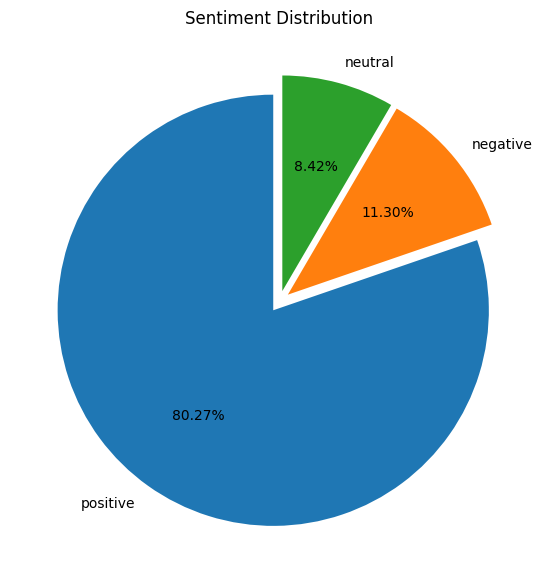

In [22]:
# Visualize class distribution as pie plot
sentiment_percent = df['sentiment'].value_counts(normalize=True)*100

plt.figure(figsize=(7,7))
plt.pie(sentiment_percent,
        labels=sentiment_percent.index,
        autopct='%1.2f%%',
        startangle=90,
        explode=[0.05]*len(sentiment_percent))
plt.title("Sentiment Distribution")
plt.show()


###Insights:
The majority of reviews are positive, indicating high customer satisfaction.
The dataset is class-imbalanced, with significantly fewer neutral and negative reviews.
Therefore, class reweighting or data augmentation may be required for model fairness.

In [24]:
# Create New Column Combining reviewtext & summary together

df['review'] = df['reviewText'] + " " + df['summary']

In [25]:
# Dropping unnecessary columns
df.drop(['reviewText', 'summary','Text_length'], axis=1, inplace=True)
df.head()

,overall,sentiment,review
0,5,positive,We got this GPS for my husband who is an (OTR)...
1,1,negative,"I'm a professional OTR truck driver, and I bou..."
2,3,neutral,"Well, what can I say. I've had this unit in m..."
3,2,negative,"Not going to write a long review, even thought..."
4,1,negative,I've had mine for a year and here's what we go...


In [26]:
# Renaming overall to rating
df.rename(columns={'overall': 'rating'},inplace=True)
df.head()

,rating,sentiment,review
0,5,positive,We got this GPS for my husband who is an (OTR)...
1,1,negative,"I'm a professional OTR truck driver, and I bou..."
2,3,neutral,"Well, what can I say. I've had this unit in m..."
3,2,negative,"Not going to write a long review, even thought..."
4,1,negative,I've had mine for a year and here's what we go...


In [28]:
# Creating a sample dataset for faster preprocessing & training
df = df.groupby('sentiment').apply(lambda x: x.sample(5000, random_state=42))
df.reset_index(drop=True, inplace=True)
df

,rating,sentiment,review
0,1,negative,The TV stations that Comcast sends my way have...
1,2,negative,Couldnt find anything else that serves this pu...
2,1,negative,This is a shame. I bought these because of so ...
3,1,negative,I installed this radio along with a Firestik a...
4,1,negative,"Bad product, and worse customer service. It d..."
...,...,...,...
14995,5,positive,Love my Chromecast so much that I ended up get...
14996,5,positive,just what you would expect. gets better and be...
14997,5,positive,This is a great alternative to ipod interface ...
14998,5,positive,This is the second ASUS laptop I buy and so fa...


# Data Preprocessing

## Remove HTML Tags
when data extracted text from a webpage text might contain HTML tags , so we need to remove those tag leaving plain text

In [29]:
# Creating as function to remove tags
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub('', str(text))

df['review'] = df['review'].apply(remove_html_tags)
df.head()

,rating,sentiment,review
0,1,negative,The TV stations that Comcast sends my way have...
1,2,negative,Couldnt find anything else that serves this pu...
2,1,negative,This is a shame. I bought these because of so ...
3,1,negative,I installed this radio along with a Firestik a...
4,1,negative,"Bad product, and worse customer service. It d..."


## Remove Punctuation

Punctuation refers to the symbols used in writing to separate sentences and parts of sentences, and to make their meaning clear. Examples include periods (.), commas (,), question marks (?), exclamation points (!), quotation marks ("), apostrophes ('), and more.

In text processing for tasks like sentiment analysis, punctuation is often removed because it typically doesn't contribute to the meaning or sentiment of the text and can increase the complexity of the data.

In [30]:
# Creating a function to remove punctuation using re inbuilt python module for Regular Expressions
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

df['review'] = df['review'].apply(remove_punctuation)
df.head()

,rating,sentiment,review
0,1,negative,The TV stations that Comcast sends my way have...
1,2,negative,Couldnt find anything else that serves this pu...
2,1,negative,This is a shame I bought these because of so m...
3,1,negative,I installed this radio along with a Firestik a...
4,1,negative,Bad product and worse customer service It did...


## Convert Text to Lowercase

Converting text to lowercase is a common step in text preprocessing. It treats words like "Hello", "hello", and "HELLO" as the same word.By converting all words to lowercase, we can reduce the number of unique tokens in our vocabulary. This can make your models more efficient and less prone to overfitting.Also many text processing models are case-sensitive. Converting to lowercase helps the model to learn the relationships between words regardless of their capitalization.

In [31]:
# Creating function to keep all text in lowercase
def to_lower(text):
    return text.lower()

df['review'] = df['review'].apply(to_lower)
df.head()

,rating,sentiment,review
0,1,negative,the tv stations that comcast sends my way have...
1,2,negative,couldnt find anything else that serves this pu...
2,1,negative,this is a shame i bought these because of so m...
3,1,negative,i installed this radio along with a firestik a...
4,1,negative,bad product and worse customer service it did...


## Remove Stopwords
Stopwords are very common words (like "the", "a", "is", "and") that appear frequently in text but often don't carry much meaning or sentiment on their own. Removing them helps to reduce the "noise" in your data and focus on the more important words.

In [32]:
# Download stopwords
nltk.download('stopwords')
negations = {'no', 'not', "don't", "didn't", "never", "cannot", "can't"} # Sometime these are important for negative sentiment
stop_words = set(stopwords.words('english')) - negations

#  Creating function to remove stopwords
def remove_stopwords(text):
    words = text.split()
    filtered = [word for word in words if word not in stop_words]
    return " ".join(filtered)

df['review'] = df['review'].apply(remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,rating,sentiment,review
0,1,negative,tv stations comcast sends way varying levels a...
1,2,negative,couldnt find anything else serves purpose coul...
2,1,negative,shame bought many good reviews light weight au...
3,1,negative,installed radio along firestik antenna tuned w...
4,1,negative,bad product worse customer service didnt play ...


### N.B.: Changed runtime type from CPU T4 GPU to avoid crush for downloading stopwords

## Remove Numbers
Number does not have any relavance with review , so we are removing number also

In [33]:
# Creating a function to remove number
def remove_numbers(text):
    return re.sub(r'\d+', '', text) # \d+ matches any sequence of one or more digits (i.e., numbers)

df['review'] = df['review'].apply(remove_numbers)
df.head()

,rating,sentiment,review
0,1,negative,tv stations comcast sends way varying levels a...
1,2,negative,couldnt find anything else serves purpose coul...
2,1,negative,shame bought many good reviews light weight au...
3,1,negative,installed radio along firestik antenna tuned w...
4,1,negative,bad product worse customer service didnt play ...


## Lemmatization

Lemmatization is a natural language processing technique that reduces words to their base or dictionary form, known as the "lemma." lemmatization considers the word's context and uses a vocabulary and morphological analysis to return a valid word.

For example:

- "running" becomes "run"
- "better" becomes "good"
- "are" becomes "be"

In [34]:
# Download wordnet + omw-1.4 for proper lemmatization — which improves sentiment analysis significantly.

nltk.download('wordnet')
nltk.download('omw-1.4')

# Create Lemmatizer tool
le = WordNetLemmatizer()

# Create a function to lemmatize
def clean_text(text):
    words = text.split()
    filtered = [le.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(filtered)

df['review'] = df['review'].apply(clean_text)
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,rating,sentiment,review
0,1,negative,tv station comcast sends way varying level aud...
1,2,negative,couldnt find anything else serf purpose could ...
2,1,negative,shame bought many good review light weight aud...
3,1,negative,installed radio along firestik antenna tuned w...
4,1,negative,bad product worse customer service didnt play ...


In [35]:
# Convert review to string
df['review'] = df['review'].astype(str)

In [37]:
# Removes extra whitespaces between words
df['review'] = df['review'].apply(lambda x: " ".join(x.split()))

In [38]:
# Removes non-ASCII characters to keep only standard English letters
df['review'] = df['review'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii')) # This code removes emojis, accents, foreign characters, symbols. Turns all text into plain English ASCII

In [39]:
# Removes very short words (1-2 letters) which are usually not meaningful.
df['review'] = df['review'].apply(lambda x: " ".join([w for w in x.split() if len(w) > 2]))

In [40]:
df.head(5)

,rating,sentiment,review
0,1,negative,station comcast sends way varying level audio ...
1,2,negative,couldnt find anything else serf purpose could ...
2,1,negative,shame bought many good review light weight aud...
3,1,negative,installed radio along firestik antenna tuned w...
4,1,negative,bad product worse customer service didnt play ...


In [41]:
# Save cleaned dataset
df.to_csv('/content/drive/MyDrive/amazon_electronics_reviews_cleaned.csv', index=False)

In [42]:
# Load cleaned dataset to train model
df = pd.read_csv('/content/drive/MyDrive/amazon_electronics_reviews_cleaned.csv')

In [43]:
df.head()

,rating,sentiment,review
0,1,negative,station comcast sends way varying level audio ...
1,2,negative,couldnt find anything else serf purpose could ...
2,1,negative,shame bought many good review light weight aud...
3,1,negative,installed radio along firestik antenna tuned w...
4,1,negative,bad product worse customer service didnt play ...


## Tokenization & Padding

* This step converts the cleaned text into sequences of integers for model input.

* pad_sequences ensures all sequences have the same length (max_len=200).

In [45]:
df['review'] = df['review'].fillna("").astype(str)

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['review']) # tokenizer learn vocabulary from the text

sequences = tokenizer.texts_to_sequences(df['review']) # converts each review from text → a sequence of integers
max_len = 100
X = pad_sequences(sequences, maxlen=max_len, padding='post')